### Assignment: Predicting House Prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

1. Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:


    - postgres_user = 'dsbc_student'
    - postgres_pw = '7*.8G9QH21'
    - postgres_host = '142.93.121.174'
    - postgres_port = '5432'
    - postgres_db = 'houseprices'
    
    - Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.

2. Investigate the data, and do any necessary data cleaning.
3. Explore the data and find some variables that you think would be useful in predicting house prices.
4. Build your initial model using these features and estimate the parameters using OLS.

Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at this [example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).

### Import Statements

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings### Import Statements

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn import linear_model
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### 1. Loading the Dataframe

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

### 2. Investigate the Data, and Do Any Necessary Data Cleaning

In [3]:
house_prices_df.shape

(1460, 81)

In [4]:
print(house_prices_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Because this dataframe has 81 columns, and most of the columns have more than 1,000 datapoints, I'm going to drop the five columns that have less than 800 datapoints. Those columns are: 'alley', 'fence', 'fireplacequ', 'poolqc' and 'miscfeature'.

I'm also going to drop 'id' because it's a numbered list of the properties.

In [5]:
fist_revision_house_prices_df = house_prices_df.drop(columns=['alley', 'fence', 'fireplacequ', 'poolqc', 'miscfeature', 'id'])

fist_revision_house_prices_df.shape

(1460, 75)

In [6]:
fist_revision_house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1452 no

Because many of the columns' data types are objects, I'm going to look at the values in those columns and see if I can use one hot encoding to transform the data into ones and zeros.

If I can't transform a column, I'm going to drop it because (in the interest of time) I'm going to use PCA for my analysis given how many variables there are.

In [7]:
# This is the code I used to check the columns.

pd.Series(' '.join(fist_revision_house_prices_df['salecondition']).split()).value_counts()[:50]

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
dtype: int64

In [8]:
second_revision_house_prices_df = fist_revision_house_prices_df.drop(columns=['mszoning', 'lotshape', 'landcontour', 
                                    'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 
                                    'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 
                                    'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtexposure', 'bsmtfintype1', 
                                    'bsmtfintype2', 'heating', 'heatingqc', 'electrical', 'kitchenqual', 'functional', 
                                    'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'saletype', 
                                    'salecondition'])

After dropping the columns, I'd like to see how many columns are left.

In [9]:
second_revision_house_prices_df.shape

(1460, 41)

That shows there are 41 columns left (there are 81 in the original dataframe). 

With that in mind, I'm going to transform the values of the object columns that are left ('street', 'utilities', 'bsmtcond' and 'centralair') using one hot encoding.

In [10]:
second_revision_house_prices_df['street'] = pd.get_dummies(second_revision_house_prices_df['street'], drop_first=True)

second_revision_house_prices_df['utilities'] = pd.get_dummies(second_revision_house_prices_df['utilities'], drop_first=True)

second_revision_house_prices_df['bsmtcond'] = pd.get_dummies(second_revision_house_prices_df['bsmtcond'], drop_first=True)

second_revision_house_prices_df['centralair'] = pd.get_dummies(second_revision_house_prices_df['centralair'], drop_first=True)

The dataframe has missing values, so I'll fill those in with the mean, which is a measure of central tendency.

To get that started, I'll re-confirm which columns are missing information.

In [11]:
(second_revision_house_prices_df.isnull().sum()*100) / second_revision_house_prices_df.isnull().count()

mssubclass        0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
utilities         0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
masvnrarea        0.547945
bsmtcond          0.000000
bsmtfinsf1        0.000000
bsmtfinsf2        0.000000
bsmtunfsf         0.000000
totalbsmtsf       0.000000
centralair        0.000000
firstflrsf        0.000000
secondflrsf       0.000000
lowqualfinsf      0.000000
grlivarea         0.000000
bsmtfullbath      0.000000
bsmthalfbath      0.000000
fullbath          0.000000
halfbath          0.000000
bedroomabvgr      0.000000
kitchenabvgr      0.000000
totrmsabvgrd      0.000000
fireplaces        0.000000
garageyrblt       5.547945
garagecars        0.000000
garagearea        0.000000
wooddecksf        0.000000
openporchsf       0.000000
enclosedporch     0.000000
threessnporch     0.000000
screenporch       0.000000
poolarea          0.000000
m

In [12]:
third_revision_house_prices_df = second_revision_house_prices_df.copy()

replace_nans_with_means_list = ['lotfrontage', 'masvnrarea', 'garageyrblt']

for col in replace_nans_with_means_list:
        third_revision_house_prices_df.fillna(third_revision_house_prices_df[replace_nans_with_means_list
        ].mean(), inplace=True)

I'm assuming the data has outliers, but I'd like to check. Since there are 41 columns, I'll check eight of the columns (or about 20% of them) for outliers.

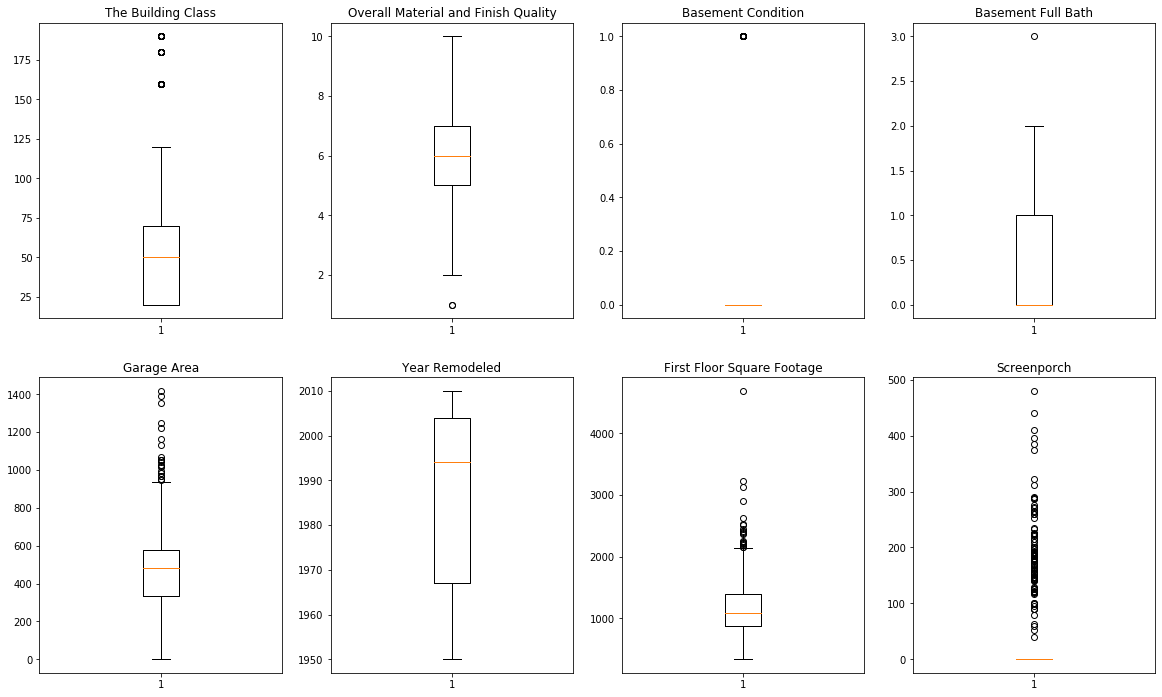

In [13]:
plt.figure(figsize=(20, 25))

plt.subplot(4, 4, 1)
plt.boxplot(third_revision_house_prices_df['mssubclass'], whis=1.5)
plt.title('The Building Class')

plt.subplot(4, 4, 2)
plt.boxplot(third_revision_house_prices_df['overallqual'], whis=1.5)
plt.title('Overall Material and Finish Quality')

plt.subplot(4, 4, 3)
plt.boxplot(third_revision_house_prices_df['bsmtcond'], whis=1.5)
plt.title('Basement Condition')

plt.subplot(4, 4, 4)
plt.boxplot(third_revision_house_prices_df['bsmtfullbath'], whis=1.5)
plt.title('Basement Full Bath')

plt.subplot(4, 4, 5)
plt.boxplot(third_revision_house_prices_df['garagearea'], whis=1.5)
plt.title('Garage Area')

plt.subplot(4, 4, 6)
plt.boxplot(third_revision_house_prices_df['yearremodadd'], whis=1.5)
plt.title('Year Remodeled')

plt.subplot(4, 4, 7)
plt.boxplot(third_revision_house_prices_df['firstflrsf'], whis=1.5)
plt.title('First Floor Square Footage')

plt.subplot(4, 4, 8)
plt.boxplot(third_revision_house_prices_df['screenporch'], whis=1.5)
plt.title('Screenporch')

plt.show()

The sample shows the outliers are skewed at the high end of the data, so I'll transform the data to normalize it.

In [25]:
fourth_revision_house_prices_df = third_revision_house_prices_df.copy()

log_transform_list = ['mssubclass', 'lotfrontage', 'lotarea', 'street', 'utilities', 'overallqual', 'overallcond', 'yearbuilt',
                 'yearremodadd', 'masvnrarea', 'bsmtcond', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'centralair',
                 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
                 'halfbath', 'bedroomabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea',
                 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
                 'mosold', 'yrsold', 'saleprice']

for col in log_transform_list:
    np.log(fourth_revision_house_prices_df[log_transform_list])

### 3. Explore the data and find some variables that you think would be useful in predicting house prices.

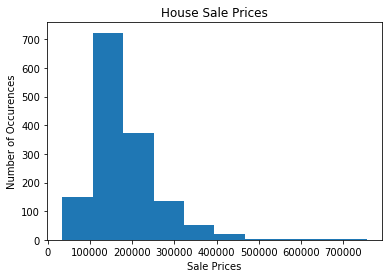

In [31]:
plt.hist(fourth_revision_house_prices_df['saleprice'])
plt.title('House Sale Prices')
plt.xlabel('Sale Prices')
plt.ylabel('Number of Occurences')

plt.show()

Even after being log transformed, the data's skewed to the left.

Text(0.5, 1, 'Correlation Matrix for the House Prices Data')

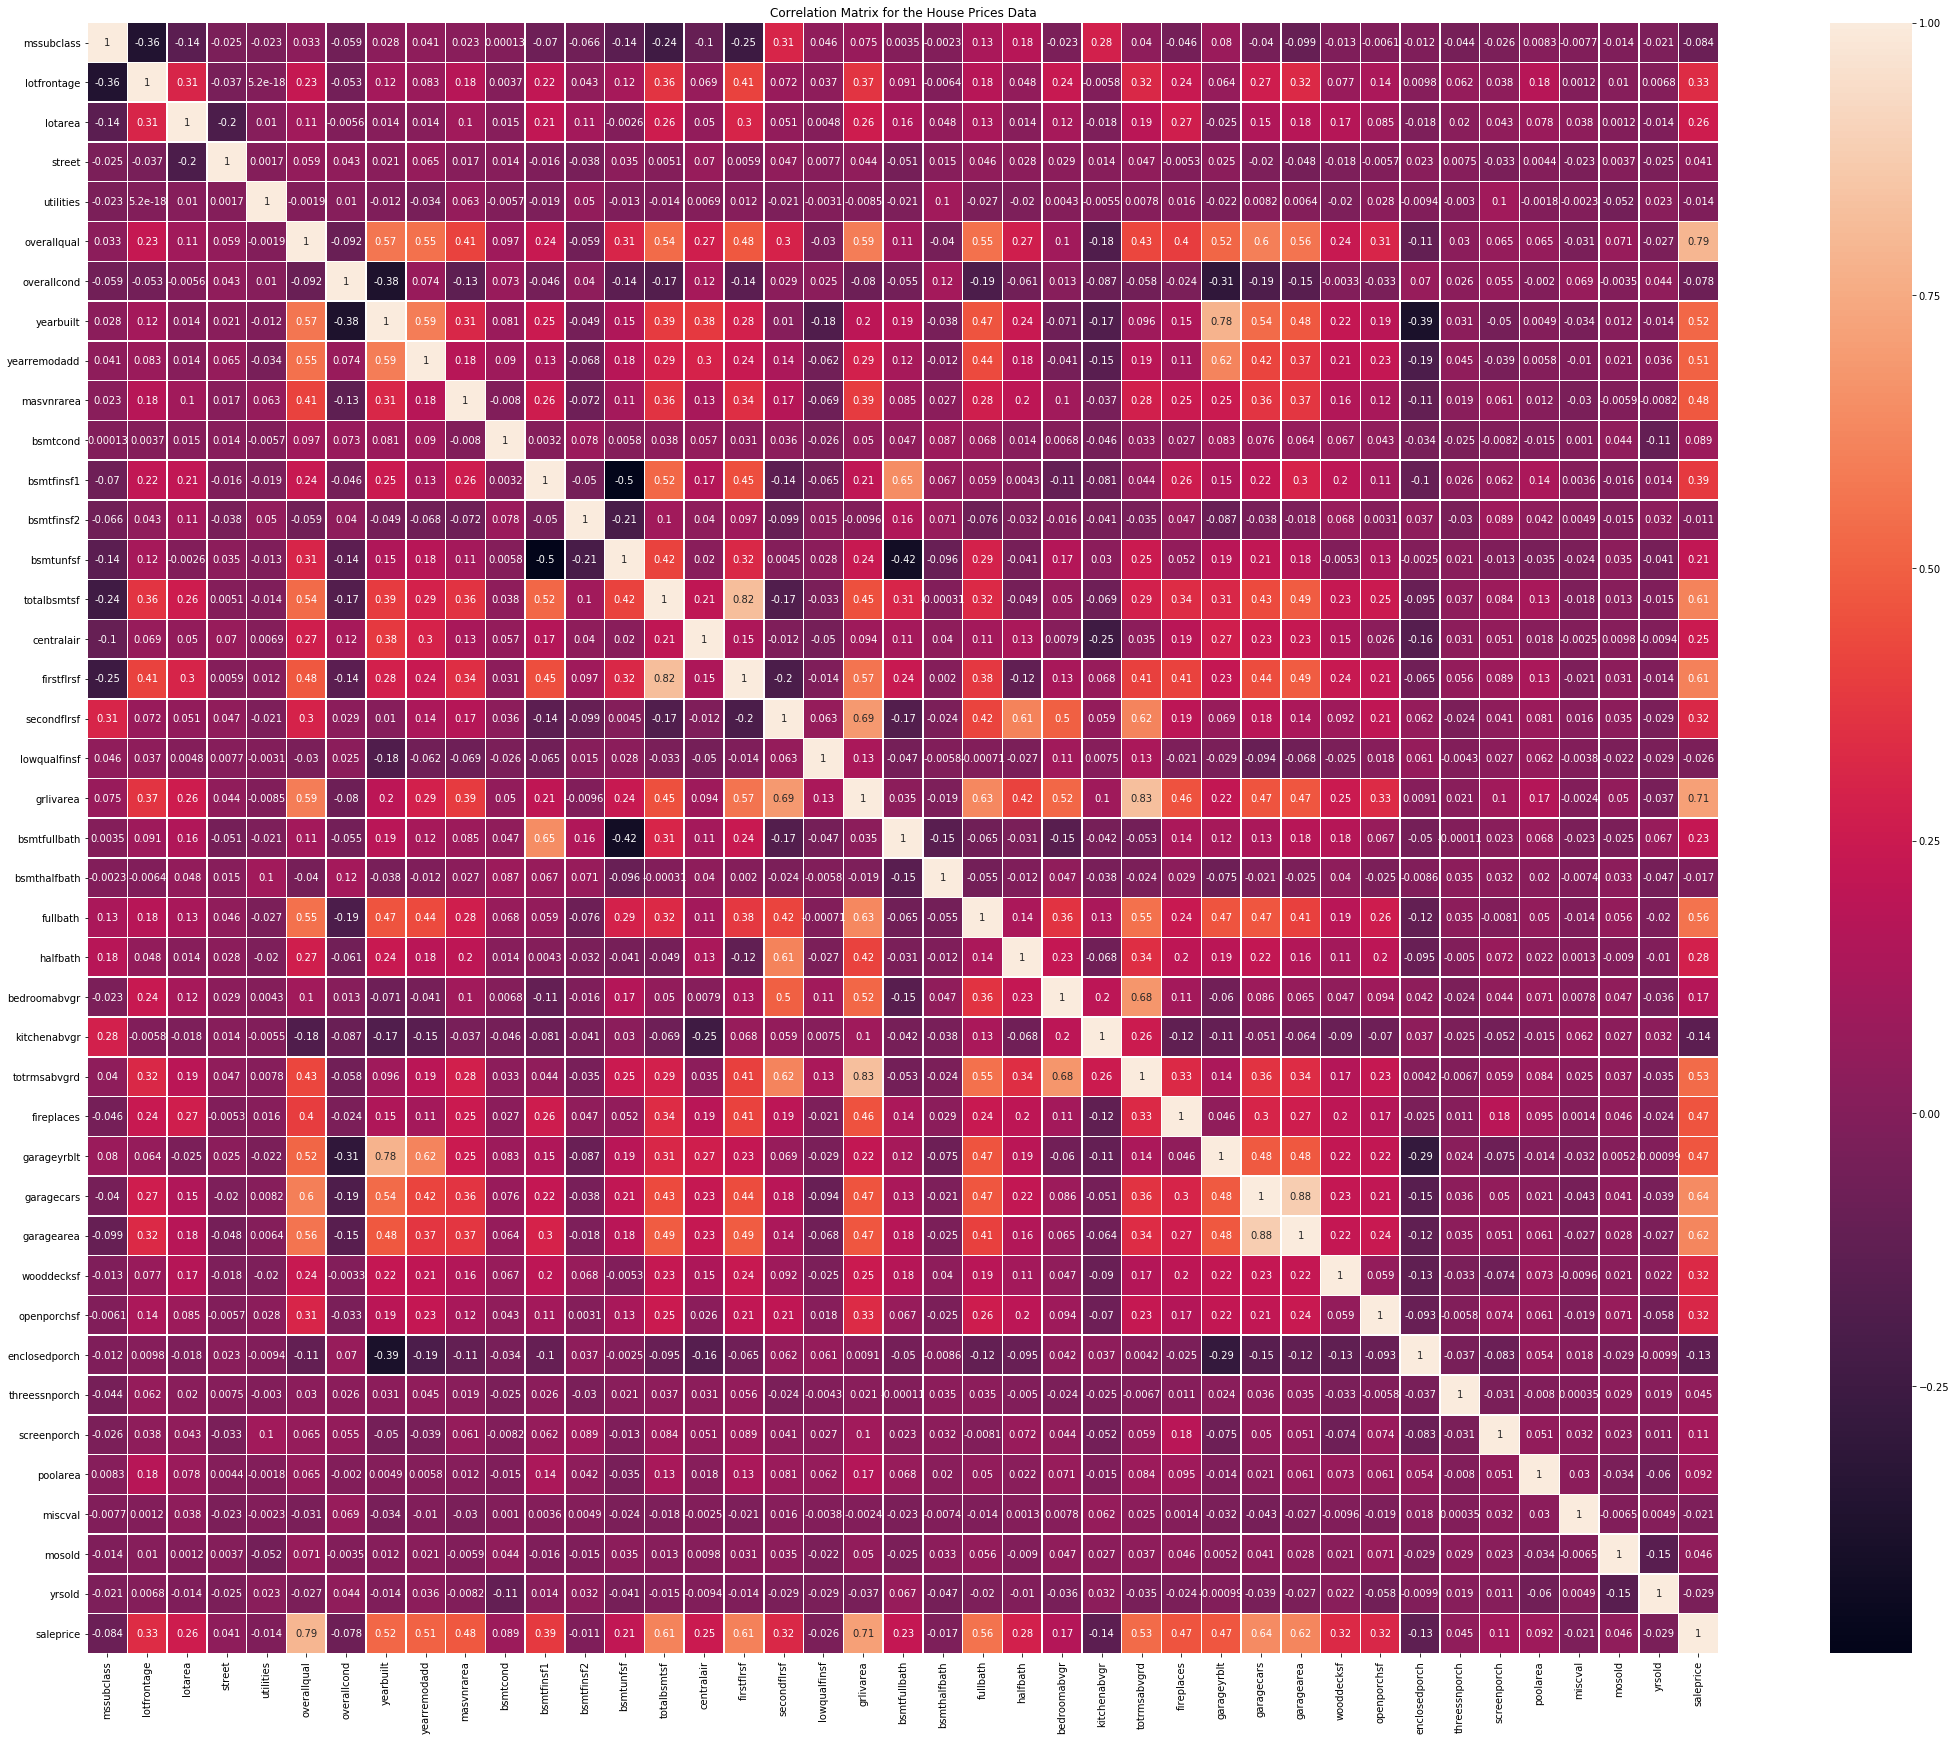

In [29]:
corrmat_fourth_revision_house_prices_df = fourth_revision_house_prices_df.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(corrmat_fourth_revision_house_prices_df, square=True, annot=True, linewidths=0.5)
plt.title('Correlation Matrix for the House Prices Data')

The correlation matrix is a bit hard to read, but the five columns with the highest correlation coefficient (CC) to 'saleprice' are: 

1. overallqual (0.79 CC)
2. grlivarea (0.71 CC)
3. garagecars (0.64 CC)
4. garagearea (0.62 CC)
5. totalbsmtsf (0.61 CC)

### 4. Build your initial model using these features and estimate the parameters using OLS.

I'll use the top two features ('overallqual' and 'grlivarea') here.

In [34]:
Y = fourth_revision_house_prices_df['saleprice']
X = fourth_revision_house_prices_df[['overallqual', 'grlivarea']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1820.
Date:                Sat, 17 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:25:40   Log-Likelihood:                -17630.
No. Observations:                1460   AIC:                         3.527e+04
Df Residuals:                    1457   BIC:                         3.528e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.041e+05   5045.372    -20.631      0.000   -1.14e+05   -9.42e+04
overallqual  3.285e+04    999.198     32.875      0.000    3.09e+04    3.48e+04
grlivarea      55.8622      2.630     21.242      0.000      50.704      61.021
==============================================================================
Omnibus:                      341.985   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8725.150
Skew:                           0.469   Prob(JB):                         0.00
Kurtosis:                      14.939   Cond. No.                     7.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""